In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import odeint, solve_bvp, solve_ivp, quad
from scipy.optimize import curve_fit

In [123]:
P_total = 1e6

In [124]:
# ---------- Function for parsing infected data ----------  #
def parse_infected_data(file):
    """Parse weekly new case count data.

    All data is in 1-week increments here.
    Testing data starts the week after the training data ends.

    Parameters:
        file (str): The path to "Summary_Case Counts Per Week.csv"

    Returns:
        train (np.ndarray) - An array of weekly new COVID case counts
            for training (the weeks from 3/8/2020 to 12/12/2021).
            Use for your gradient descent algorithm and modeling.
        test (np.ndarray) - An array of weekly new COVID case counts
            for testing (the weeks from 12/19/2021 to 1/19/2022).
            Only use to test the performance of your model on its
            learned parameters after you run your gradient descent
            algorithm.
        t_train (list) - A list of numbered weeks
            corresponding to the training data (starting with 1)
        t_test (list) - A list of numbered weeks
            corresponding to the testing data (starting 1 after
            the training data)
    """
    # Get the case count data from the csv into Python
    data = pd.read_csv(file, index_col=0)

    # Split the data into a training set(before 12/12/2021)
    # and a testing set (12/19/2021-1/19/2022)
    #train = data[:]['New Cases'].to_numpy()
    train = data[:'2021-12-12']['New Cases'].to_list()
    test = data['2021-12-19':'2022-01-19']['New Cases'].to_list()

    # Get week enumerations for this data (for ease of use)
    t_train = [i for i in range(1, len(train) + 1)]
    t_test = [i for i in range(len(train)+1, len(test)+len(train)+1)]
    return train, test, t_train, t_test



# ---------- Example for how to use the above function ----------  #
csv_file = 'COVID_Data_SLC/Summary_Case Counts per Week.csv'
case_count_data, case_count_pred, t_cc_data, t_cc_pred = parse_infected_data(csv_file)
case_count_data = (np.array(case_count_data) / P_total).tolist()


In [125]:
# ---------- Function for parsing infected data ----------  #
def parse_death_data(file):
    """Parse weekly new case count data.

    All data is in 1-week increments here.
    Testing data starts the week after the training data ends.

    Parameters:
        file (str): The path to "Summary_Case Counts Per Week.csv"

    Returns:
        train (np.ndarray) - An array of weekly new COVID case counts
            for training (the weeks from 3/8/2020 to 12/12/2021).
            Use for your gradient descent algorithm and modeling.
        test (np.ndarray) - An array of weekly new COVID case counts
            for testing (the weeks from 12/19/2021 to 1/19/2022).
            Only use to test the performance of your model on its
            learned parameters after you run your gradient descent
            algorithm.
        t_train (list) - A list of numbered weeks
            corresponding to the training data (starting with 1)
        t_test (list) - A list of numbered weeks
            corresponding to the testing data (starting 1 after
            the training data)
    """
    # Get the case count data from the csv into Python
    data = pd.read_csv(file, index_col=0)

    # Split the data into a training set(before 12/12/2021)
    # and a testing set (12/19/2021-1/19/2022)
    train = data[:'2021-12-12']['New Deaths'].to_list()
    test = data['2021-12-19':'2022-01-19']['New Deaths'].to_list()

    # Get week enumerations for this data (for ease of use)
    t_train = [i for i in range(1, len(train) + 1)]
    t_test = [i for i in range(len(train)+1, len(test)+len(train)+1)]
    return train, test, t_train, t_test



# ---------- Example for how to use the above function ----------  #
csv_file = 'COVID_Data_SLC/Deaths_Counts per Week.csv'
death_data, death_pred, t_death_data, t_death_pred = parse_death_data(csv_file)
death_data = 2*[0] + death_data
death_data = (np.array(death_data) / P_total).tolist()


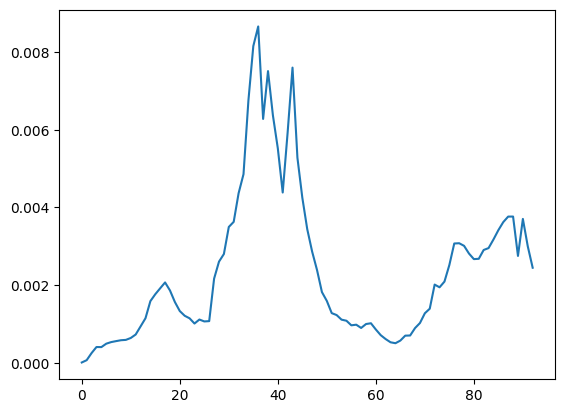

93


In [126]:
plt.plot(case_count_data)
plt.show()
print(len(case_count_data))

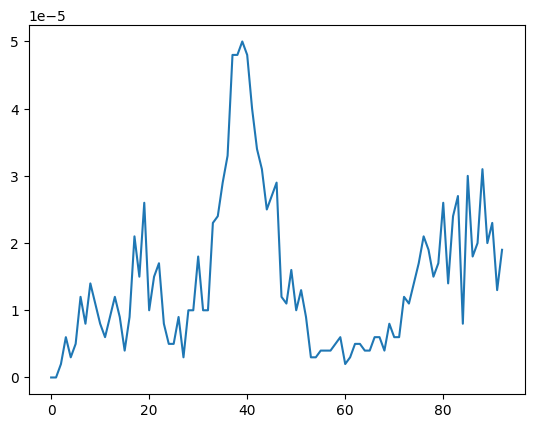

93


In [127]:
plt.plot(death_data)
plt.show()
print(len(death_data))

In [783]:
from sympy import *
from sympy import Function, Symbol
# initialize ODE dependent variables
S, I1, I2, I3, R, D = symbols('S, I1, I2, I3, R, D ')

# initialize parmeters
k, a, r = symbols('k, a, r')

sys_vars = [S, I1, I2, I3, R, D] # vector of ODE variables
params = [k, a, r] # vector of parameters

Io, Ro, Do = symbols('Io, Ro, Do') # data for the variables

# functional we wish to minimize
J_integrand = 1/2*((I1 + I2 + I3 - Io)**2 + 0.03*(R - Ro)**2 + 5*(D - Do)**2)

# Right hand side of the ODE (must be first order IVP)
RHS_ODE = [-k*S*(I1 + a*I2), \
           k*S*(I1 + a*I2) - I1, \
           I1 - I2, \
           I2 - I3, \
           (1 - r)*I3, \
           r*I3]

# create adjoint variables
advars = []
for j in range(len(sys_vars)):
  advars.append(sympify("P_{}".format(str(sys_vars[j]))))
print(advars)

# Find the RHS of the adjoint equations.

# WARNING: This assumes that J looks like $\int_0^T (I-I_{observations})^2dt$ and not like $\int_0^T k*(I-I_{observations})^2dt$.

# WARNING: Make sure the sign is right for these based on how you set up your augmented functional.

d_sys = []
for j in range(len(sys_vars)):
  derivative = diff(J_integrand, sys_vars[j])
  for i, rhs in enumerate(RHS_ODE):
    derivative -= diff(rhs, sys_vars[j])*advars[i]
  d_sys.append(derivative)

d_sys

[P_S, P_I1, P_I2, P_I3, P_R, P_D]


[-P_I1*k*(I1 + I2*a) + P_S*k*(I1 + I2*a),
 1.0*I1 + 1.0*I2 + 1.0*I3 - 1.0*Io - P_I1*(S*k - 1) - P_I2 + P_S*S*k,
 1.0*I1 + 1.0*I2 + 1.0*I3 - 1.0*Io - P_I1*S*a*k + P_I2 - P_I3 + P_S*S*a*k,
 1.0*I1 + 1.0*I2 + 1.0*I3 - 1.0*Io - P_D*r + P_I3 - P_R*(1 - r),
 0.03*R - 0.03*Ro,
 5.0*D - 5.0*Do]

In [784]:
d_param = []
for j in range(len(params)):
  derivative = diff(J_integrand, params[j])
  for i, rhs in enumerate(RHS_ODE):
    derivative -= diff(rhs, params[j])*advars[i]
  d_param.append(derivative)

d_param

[-P_I1*S*(I1 + I2*a) + P_S*S*(I1 + I2*a),
 -I2*P_I1*S*k + I2*P_S*S*k,
 -I3*P_D + I3*P_R]

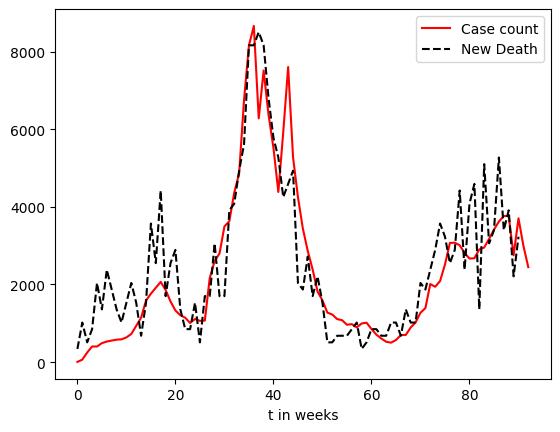

In [962]:
fig = plt.figure()
plt.plot(np.array(case_count_data) * P_total, 'r', label="Case count")
plt.plot(np.array(death_data[2:])*170 * P_total, 'k--', label="New Death")
plt.legend()
plt.xlabel("t in weeks")
plt.show()
fig.savefig("SIR2_CCvsND.png")

In [786]:
N = len(case_count_data)

I1_data = np.array(case_count_data)
I2_data = np.array([0] + case_count_data[:-1])
I3_data = np.array([0]*2 + case_count_data[:-2])
I2t_data = I1_data - I2_data
I3t_data = I2_data - I3_data

I_total_data = I1_data + I2_data + I3_data

Dt_data = np.array(death_data)
D_data = np.array([sum(Dt_data[:i+1]) for i in range(N)])
Rt_data = I3_data - Dt_data
R_data = np.array([sum(Rt_data[:i+1]) for i in range(N)])

S_data = np.ones(N) - I_total_data - R_data - D_data
St_data = np.array([0] + [S_data[t+1] - S_data[t] for t in range(N - 1)])

I1t_data = -St_data - I1_data

In [787]:
Io = np.poly1d(np.polyfit(t_cc_data, I_total_data, 20))
Ro = np.poly1d(np.polyfit(t_cc_data, R_data, 20))
Do = np.poly1d(np.polyfit(t_cc_data, D_data, 20))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3508: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3508: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3508: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


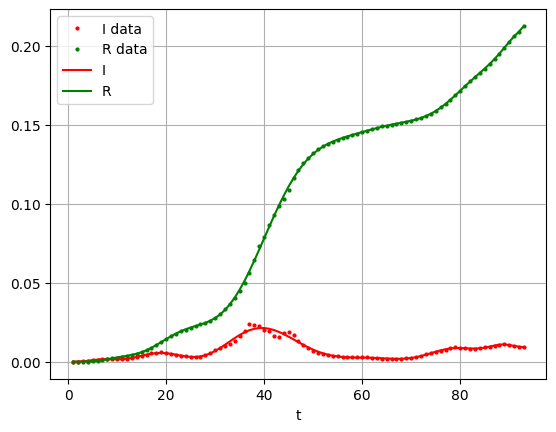

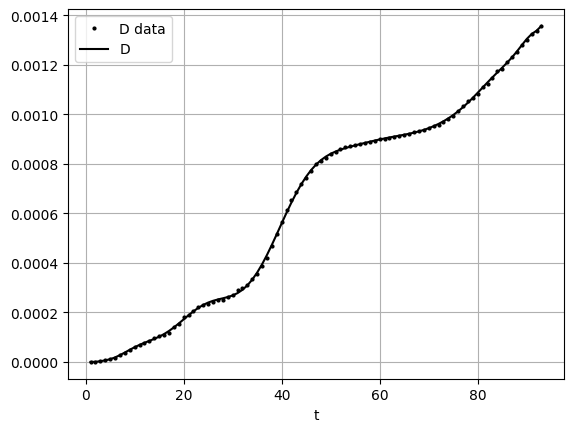

In [788]:
plt.plot(t_cc_data, I_total_data,'ro', label='I data', ms = 2)
plt.plot(t_cc_data, R_data,'go', label='R data', ms = 2)

plt.plot(t_cc_data, Io(t_cc_data), 'r', label="I")
plt.plot(t_cc_data, Ro(t_cc_data), 'g', label="R")
plt.legend(loc='upper left')
plt.xlabel('t')
plt.grid()
plt.show()

plt.plot(t_cc_data, D_data,'ko', label='D data', ms = 2)
plt.plot(t_cc_data, Do(t_cc_data), 'k', label="D")
plt.legend(loc='upper left')
plt.xlabel('t')
plt.grid()
plt.show()

In [789]:
r_guess = 1 / np.mean(I3_data[2:] / Dt_data[2:])
1 / r_guess

169.59646406295073

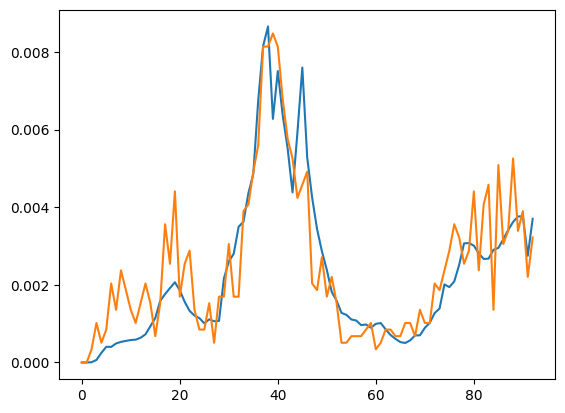

In [790]:
plt.plot(I3_data)
plt.plot(Dt_data/r_guess)

In [791]:
def fourier_series(t, *args):
    t = np.array(t)
    N = (len(args) - 1) // 2
    c = args[0]
    a = args[1:N+1]
    b = args[N+1:]
    return c + sum(a[i]*np.cos(2*np.pi*t*i/52) + b[i]*np.sin(2*np.pi*t*i/52) for i in range(N))

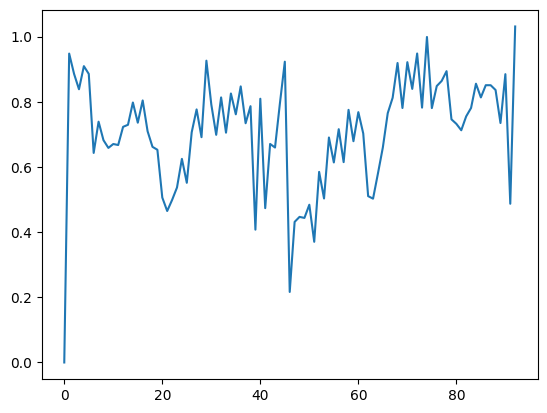

In [792]:
a_guess = 0.6
k_data = -St_data / (S_data*(I1_data + a_guess*I2_data))
plt.plot(k_data)

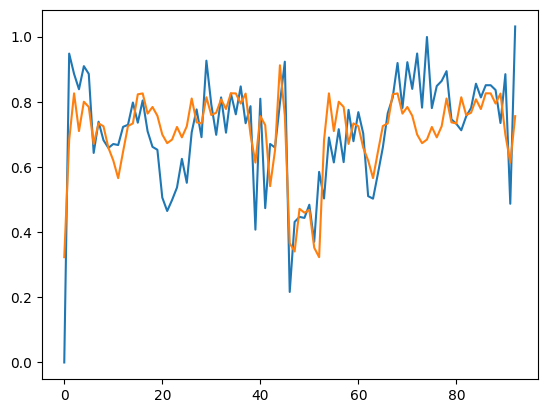

In [887]:
k_guess, _ = curve_fit(fourier_series, t_cc_data, k_data, p0=(0.8, *np.zeros(20), *np.zeros(20)))
plt.plot(k_data)
plt.plot(fourier_series(t_cc_data, *k_guess))

In [888]:
def ode_fun(t, u, *args):
    k = fourier_series(t, *args[:-2])
    a = args[-2]
    r = args[-1]

    out = np.zeros(6)

    S = u[0]
    I1 = u[1]
    I2 = u[2]
    I3 = u[3]
    R = u[4]
    D = u[5]

    out[0] = -k*S*(I1 + a*I2)
    out[1] = k*S*(I1 + a*I2) - I1
    out[2] = I1 - I2
    out[3] = I2 - I3
    out[4] = (1 - r)*I3
    out[5] = r*I3

    return out

# Initial guess
I1_0 = 0.0002
I2_0 = 0
I3_0 = 0
R_0 = 0
D_0 = 0
S_0 = 1 - I1_0 - I2_0 - I3_0 - R_0 - D_0

u0 = [S_0, I1_0, I2_0, I3_0, R_0, D_0]
SIR_sol = solve_ivp(ode_fun, [0, 104], u0, args=(*k_guess, a_guess, r_guess), dense_output=True)

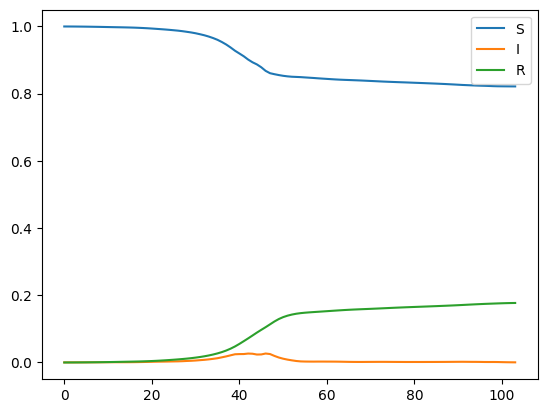

In [889]:
t = np.arange(104)
I_total = SIR_sol.sol(t)[1] + SIR_sol.sol(t)[2] + SIR_sol.sol(t)[3]
plt.plot(t, SIR_sol.sol(t)[0], label="S")
plt.plot(t, I_total, label="I")
plt.plot(t, SIR_sol.sol(t)[4], label="R")
plt.legend()
plt.show()

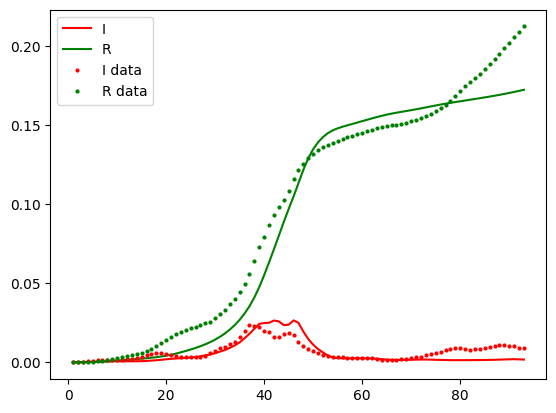

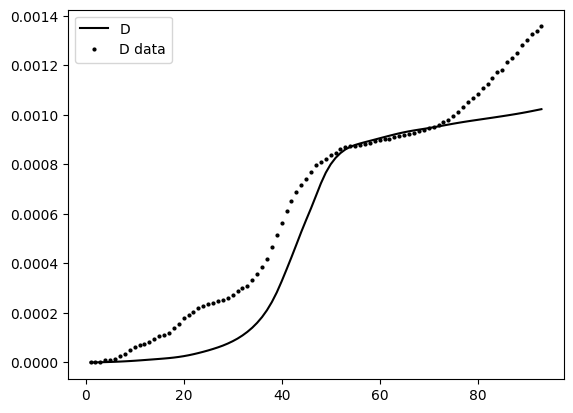

In [890]:
time_steps = np.array(t_cc_data)
I_total = SIR_sol.sol(time_steps)[1] + SIR_sol.sol(time_steps)[2] + SIR_sol.sol(time_steps)[3]

plt.plot(time_steps, I_total, 'r', label="I")
plt.plot(time_steps, SIR_sol.sol(time_steps)[4], 'g', label="R")
plt.plot(time_steps, I_total_data,'ro', label='I data', ms = 2)
plt.plot(time_steps, R_data,'go', label='R data', ms = 2)
plt.legend()
plt.show()

plt.plot(time_steps, SIR_sol.sol(time_steps)[5], 'k', label="D")
plt.plot(time_steps, D_data,'ko', label='D data', ms = 2)
plt.legend()
plt.show()

In [797]:
def ode_adjoint(t, P):
    k_out = fourier_series(t, *k_guess)

    S = SIR_sol.sol(t)[0]
    I1 = SIR_sol.sol(t)[1]
    I2 = SIR_sol.sol(t)[2]
    I3 = SIR_sol.sol(t)[3] 
    R = SIR_sol.sol(t)[4]
    D = SIR_sol.sol(t)[5]
    
    P_S = k_out*(I1 - a_guess*I2)*(P[0] - P[1])
    P_I1 = I1 + I2 + I3 - Io(t) + k_out*S*(P[0] - P[1]) + P[1] - P[2]
    P_I2 = I1 + I2 + I3 - Io(t) + a_guess*k_out*S*(P[0] - P[1]) + P[2] - P[3]
    P_I3 = I1 + I2 + I3 - Io(t) - (1-r_guess)*P[4] - r_guess*P[5] + P[3]
    P_R = 0.03*(R - Ro(t))
    P_D = 5*(D - Do(t))

    return np.vstack([P_S, P_I1, P_I2, P_I3, P_R, P_D])

def adjoint_bc(Pa, Pb):
    return np.array([Pb[0], Pb[1], Pb[2], Pb[3], Pb[4], Pb[5]])

t_mesh = np.linspace(0, 93, 10)
P0 = np.ones((6, t_mesh.size))
p = solve_bvp(ode_adjoint, adjoint_bc, t_mesh, P0)

In [798]:
J_k_func = lambda t: SIR_sol.sol(t)[0] * (SIR_sol.sol(t)[1] + a_guess*SIR_sol.sol(t)[2]) * (p.sol(t)[0] - p.sol(t)[1])
J_a_func = lambda t: fourier_series(t, *k_guess) * SIR_sol.sol(t)[0] * SIR_sol.sol(t)[2] * (p.sol(t)[0] - p.sol(t)[1])
J_r_func = lambda t: SIR_sol.sol(t)[3] * (p.sol(t)[4] - p.sol(t)[5])

J_k = sum(J_k_func(t) for t in time_steps)
J_a = sum(J_a_func(t) for t in time_steps)
J_r = sum(J_r_func(t) for t in time_steps)

J_S0 = -p.sol(0)[0]
J_I10 = -p.sol(0)[1]
J_I20 = -p.sol(0)[2]
J_I30 = -p.sol(0)[3]
J_R0 = -p.sol(0)[4]
J_D0 = -p.sol(0)[5]

J_k, J_a, J_r

(0.08102575301302016, 0.0344191426571448, -0.0027368920425493567)

In [799]:
J_S0, J_I10, J_I20, J_I30, J_R0, J_D0

(0.018815996902917593,
 8.135052342091246,
 2.812132750850415,
 -0.00791924768375553,
 -0.008356299754752775,
 -0.03896303291154712)

In [800]:
np.set_printoptions(suppress=True, precision=8)

In [891]:
N = len(t_cc_data)
num_coefs = 20
k = np.copy(k_guess)
#k = np.array([0.7] + [*np.zeros(2*num_coefs)])
a = a_guess + 0
r = r_guess + 0
I1_0 = 0.0002
I2_0 = 0
I3_0 = 0
R_0 = 0
D_0 = 0
S_0 = 1 - I1_0 - I2_0 - I3_0 - R_0 - D_0
u0 = np.array([S_0, I1_0, I2_0, I3_0, R_0, D_0])

cost_hist = []
param_hist = []

In [947]:
n_iter = 20
lr = 0.0001
for i in range(n_iter):
    print("Step {}".format(i))
    
    def ode_fun(t, u, *args):
        _k = fourier_series(t, *args[:-2])
        _a = args[-2]
        _r = args[-1]

        out = np.zeros(6)

        S = u[0]
        I1 = u[1]
        I2 = u[2]
        I3 = u[3]
        R = u[4]
        D = u[5]

        out[0] = -_k*S*(I1 + _a*I2)
        out[1] = _k*S*(I1 + _a*I2) - I1
        out[2] = I1 - I2
        out[3] = I2 - I3
        out[4] = (1 - _r)*I3
        out[5] = _r*I3

        return out
    
    SIR_sol = solve_ivp(ode_fun, [0, 104], u0, args=(*k, a, r), dense_output=True)

    cost_func = lambda t: (SIR_sol.sol(t)[1]+SIR_sol.sol(t)[2]+SIR_sol.sol(t)[3] - Io(t))**2 + 0.03*(SIR_sol.sol(t)[4] - Ro(t))**2 + 5*(SIR_sol.sol(t)[5] - Do(t))**2
    J = 0.5 * sum(cost_func(t) for t in range(N))
    print("Cost: {:.6}".format(J))
    cost_hist.append(J)

    def ode_adjoint(t, P):
        k_out = fourier_series(t, *k)

        S = SIR_sol.sol(t)[0]
        I1 = SIR_sol.sol(t)[1]
        I2 = SIR_sol.sol(t)[2]
        I3 = SIR_sol.sol(t)[3] 
        R = SIR_sol.sol(t)[4]
        D = SIR_sol.sol(t)[5]
        
        P_S = k_out*(I1 - a*I2)*(P[0] - P[1])
        P_I1 = I1 + I2 + I3 - Io(t) + k_out*S*(P[0] - P[1]) + P[1] - P[2]
        P_I2 = I1 + I2 + I3 - Io(t) + a*k_out*S*(P[0] - P[1]) + P[2] - P[3]
        P_I3 = I1 + I2 + I3 - Io(t) - (1-r)*P[4] - r*P[5] + P[3]
        P_R = 0.03*(R - Ro(t))
        P_D = 5*(D - Do(t))

        return np.vstack([P_S, P_I1, P_I2, P_I3, P_R, P_D])

    def adjoint_bc(Pa, Pb):
        return np.array([Pb[0], Pb[1], Pb[2], Pb[3], Pb[4], Pb[5]])

    t_mesh = np.linspace(0, 93, 10)
    P0 = np.ones((6, t_mesh.size))
    p = solve_bvp(ode_adjoint, adjoint_bc, t_mesh, P0)

    J_k_func = lambda t: SIR_sol.sol(t)[0] * (SIR_sol.sol(t)[1] + a*SIR_sol.sol(t)[2]) * (p.sol(t)[0] - p.sol(t)[1])
    J_a_func = lambda t: fourier_series(t, *k) * SIR_sol.sol(t)[0] * SIR_sol.sol(t)[2] * (p.sol(t)[0] - p.sol(t)[1])
    J_r_func = lambda t: SIR_sol.sol(t)[3] * (p.sol(t)[4] - p.sol(t)[5])

    J_kc = sum(J_k_func(t) for t in range(N))
    J_ka = []
    J_kb = []
    
    for i in range(1, num_coefs+1):
        J_ka.append(sum(J_k_func(t)*np.cos(2*np.pi*t*i/52) for t in time_steps))
        J_kb.append(sum(J_k_func(t)*np.sin(2*np.pi*t*i/52) for t in time_steps))

    J_a = sum(J_a_func(t) for t in range(N))
    J_r = sum(J_r_func(t) for t in range(N))

    J_S0 = -p.sol(0)[0]
    J_I10 = -p.sol(0)[1]
    J_I20 = -p.sol(0)[2]
    J_I30 = -p.sol(0)[3]
    J_R0 = -p.sol(0)[4]
    J_D0 = -p.sol(0)[5]

    u_grad = np.array([J_I10 - J_S0, J_I20 - J_S0, J_I30 - J_S0, J_R0 - J_S0, J_D0 - J_S0])
    k_grad = np.array([J_kc] + J_ka + J_kb)

    # print(k_grad)
    # print(u_grad)
    # print(J_a)
    # print(J_r)
    # print()

    # print(u0)
    # print(k)
    # print(a)
    # print(r)
    # print()

    k -= lr*k_grad / np.linalg.norm(k_grad)
    a -= lr*J_a
    r -= lr*J_r
    u0[1:] -= 0.001*lr*u_grad / np.linalg.norm(u_grad)
    u0[0] = 1 - u0[1] - u0[2] - u0[3] - u0[4] - u0[5]

    # print(u0)
    # print(k)
    # print(a)
    # print(r)

    print()



    

Step 0
Cost: 0.000745691

Step 1
Cost: 0.000745828

Step 2
Cost: 0.000745971

Step 3
Cost: 0.000746121

Step 4
Cost: 0.000746275

Step 5
Cost: 0.000746435

Step 6
Cost: 0.000746599

Step 7
Cost: 0.000746768

Step 8
Cost: 0.000746947

Step 9
Cost: 0.000747176

Step 10
Cost: 0.000747384

Step 11
Cost: 0.000747671

Step 12
Cost: 0.000747855

Step 13
Cost: 0.000748113

Step 14
Cost: 0.000748314

Step 15
Cost: 0.000748514

Step 16
Cost: 0.0007488

Step 17
Cost: 0.000748989

Step 18
Cost: 0.000749215

Step 19
Cost: 0.000749481



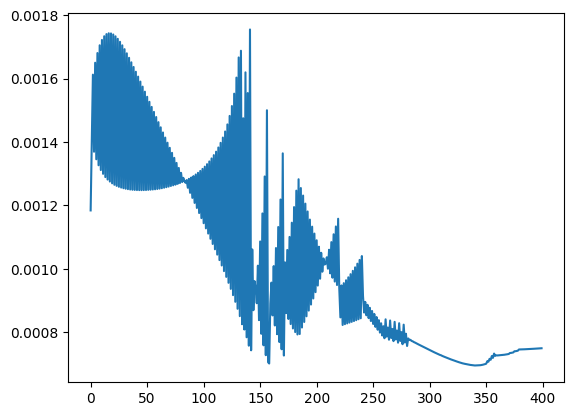

In [948]:
plt.plot(cost_hist)

In [949]:
k

array([ 57.48642452, -56.78209176,  -0.07012882,   0.01618651,
        -0.01274504,  -0.05142957,  -0.05118293,   0.00753639,
         0.00913956,  -0.00267232,  -0.00996624,  -0.00664213,
        -0.02268008,  -0.03569664,  -0.02644848,  -0.00123349,
         0.02166831,   0.01949752,   0.00226106,   0.00327176,
         0.02564312,  -0.04254572,   0.08643716,  -0.00465007,
         0.00462328,   0.03471998,  -0.00251953,   0.0124597 ,
         0.00100724,  -0.01817027,  -0.03367767,  -0.04196022,
        -0.0333698 ,  -0.00793284,   0.01133088,   0.02040032,
        -0.0203464 ,  -0.02006492,  -0.03332846,  -0.01094087,
        -0.01114167])

In [950]:
a, r

(0.6174451108985144, 0.006299441784569976)

In [951]:
u0

array([ 0.9999363 ,  0.00008816, -0.00003986,  0.00000234,  0.00000273,
        0.00001032])

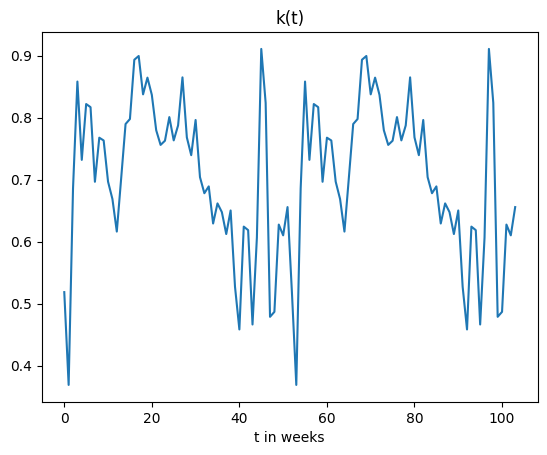

In [963]:
t = np.arange(104)
fig = plt.figure()
plt.plot(fourier_series(t, *k))
plt.title("k(t)")
plt.xlabel("t in weeks")
plt.show()
fig.savefig("SIR2_k.png")

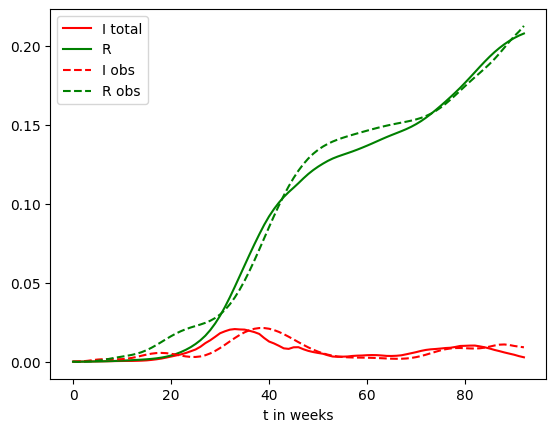

In [965]:
I_total = SIR_sol.sol(t_cc_data)[1] + SIR_sol.sol(t_cc_data)[2] + SIR_sol.sol(t_cc_data)[3]
fig = plt.figure()
plt.plot(I_total, 'r', label="I total")
plt.plot(SIR_sol.sol(t_cc_data)[4], 'g', label="R")
plt.plot(Io(t_cc_data), 'r--', label="I obs")
plt.plot(Ro(t_cc_data), 'g--', label="R obs")
plt.legend()
plt.xlabel("t in weeks")
plt.show()
fig.savefig("SIR2_FvO.png")

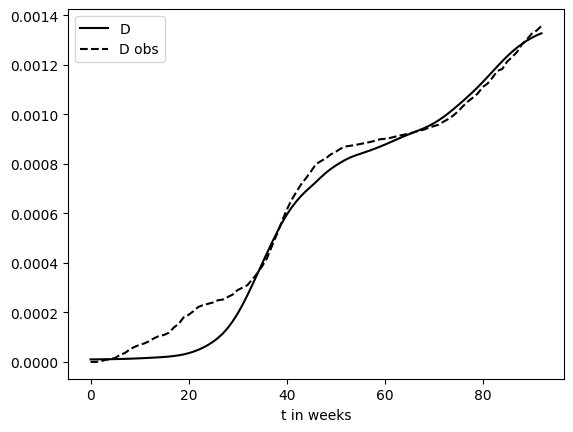

In [967]:
fig = plt.figure()
plt.plot(SIR_sol.sol(t_cc_data)[5], 'k', label="D")
plt.plot(D_data, 'k--', label="D obs")
plt.legend()
plt.xlabel("t in weeks")
plt.show()
fig.savefig("SIR2_deathFvO.png")

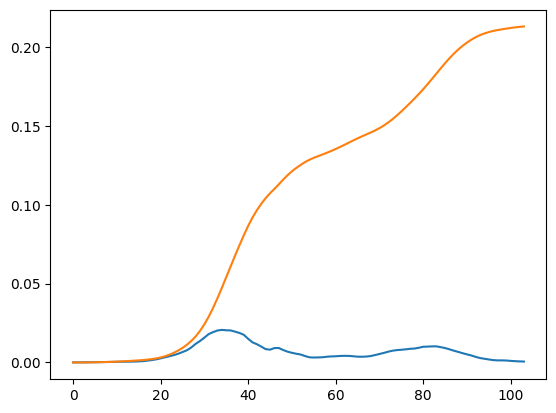

In [955]:
t = np.arange(104)
I_total = SIR_sol.sol(t)[1] + SIR_sol.sol(t)[2] + SIR_sol.sol(t)[3]
plt.plot(I_total)
plt.plot(SIR_sol.sol(t)[4])

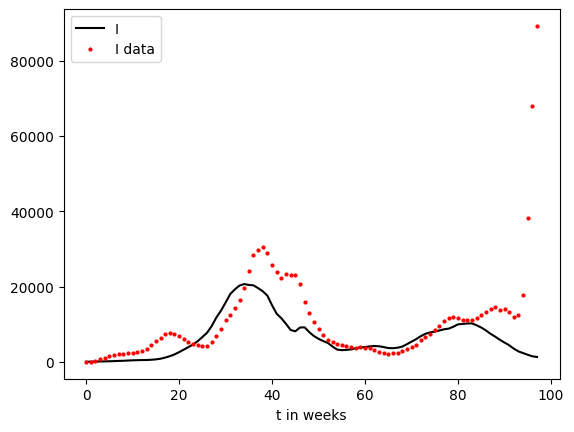

In [972]:
all_case_data = list(np.array(case_count_data) * P_total) + case_count_pred
I_full_data = np.array([sum(all_case_data[:k]) for k in range(1, 4)] + [sum(all_case_data[k:k+4]) for k in range(len(all_case_data) - 3)])
t = np.arange(len(all_case_data))
I_total = SIR_sol.sol(t)[1] + SIR_sol.sol(t)[2] + SIR_sol.sol(t)[3]
fig = plt.figure()
plt.plot(I_total*P_total, 'k', label="I")
plt.plot(I_full_data,'ro', label='I data', ms = 2)
plt.legend()
plt.xlabel("t in weeks")
plt.plot()
fig.savefig("SIR_pred1.png")